### Flexible Paleoclimate Age-Depth Models Using an Autoregressive Gamma Process

In [105]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from twalk import  pytwalk
import pandas as pd
from numba import njit
from calib import calibrate

In [88]:
# Parameters
confidence_range = 95

delta_c = 5 # space between adjacent sections

# accumulation rate parameters
acc_shape = 1.5
acc_mean = 50 # mean of accumulation rate (yr/cm unit)

# memory strength parameters
mem_strength = 10
mem_mean = 0.5 # mean of memory strength [0,1]. 0 means no memory, 1 means full memory

# Student-t parameters
a = 3
b = 4

In [89]:
# Setting parameters for Gamma distribution
# mean of gamma dist = alpha * beta
a_alpha = acc_shape
a_beta = acc_shape / acc_mean

# Setting parameters for Beta distribution
# mean of beta dist = aw / (aw + bw)
aw = mem_strength
bw = (aw - mem_mean * aw) / mem_mean

ds = 1

In [90]:
# load data
dataset = pd.read_csv('dataset.csv')
calib_curve = pd.read_csv('calib_curves/intcal20.csv')

y = dataset['age'].values
depths = dataset['depth'].values
error = dataset['error'].values

M = len(y)
K = int(((depths.max() - depths.min()) // 5) + 2)

# equally spaced sections
c = depths.min() + np.arange(K) * delta_c
K

43

In [91]:
# calibration curve (IntCal20)
# returns (age, sigma)
cal_bp = calib_curve['CAL BP'][::-1]
c14_age = calib_curve['14C age'][::-1]
sigma = calib_curve['Sigma'][::-1]

def mu(theta):
    return np.interp(theta, cal_bp, c14_age), np.interp(theta, cal_bp, sigma)

# precomputing the interpolated values for all possible calender years
calibrated_age, calibrated_std = mu(np.arange(cal_bp.min(), cal_bp.max() + 1))

In [92]:
# semi-parametric model to calculate calendar years for a given depth
# returns calendar year
# expects partitioned x values
@njit
def G(theta, x, d):
    i = int((d - depths.min()) / delta_c)

    sum_part = (x[:i+1] * delta_c).sum()
    remainder = x[i + 1] * (d - c[i])
    return theta + sum_part + remainder

@njit
def compute_G_values(theta, x, depths):
    # n = len(depths)
    # G_values = np.empty(n, dtype=np.float64)
    # for idx in range(n):
    #     G_values[idx] = G(theta, x, depths[idx])
    G_values = np.array([G(theta, x, d) for d in depths])
        
    return G_values

In [93]:
# prior for theta. theta ~ N(y[0], error[0]) (Christen Fox 2010).
def theta_prior(theta):
    return norm.pdf(theta, loc=y[0], scale=error[0])

In [94]:
x = np.zeros(K + 2, dtype=np.float64) # x[0] = theta and x[-1] = w
x_dash = np.zeros(K + 2, dtype=np.float64)
# set initial values
# theta
x[0] = np.random.normal(y[0], error[0])
x_dash[0] = np.random.normal(y[0], error[0])

# setting initial values for w
x[-1] = np.random.beta(aw, bw)**delta_c
x_dash[-1] = np.random.beta(aw, bw)**delta_c

# setting initial values for xnp
x[K] = np.random.gamma(a_alpha, a_beta / (1 - x[-1]))
x_dash[K] = np.random.gamma(a_alpha, a_beta / (1 - x_dash[-1]))

for i in range(K - 1, 0, -1):
    x[i] = x[-1] * x[i + 1] + np.random.gamma(a_alpha, a_beta / (1 - x[-1]))
    x_dash[i] = x_dash[-1] * x_dash[i + 1] + np.random.gamma(a_alpha, a_beta / (1 - x_dash[-1]))

In [95]:
# "enery" function U(theta, x, w | y) = -log (f(theta, x, w | y))
def energy(x):
    theta = x[0]
    w = x[K + 1]

    G_values = compute_G_values(theta, x[1 : K + 1], depths)
    mu_values = calibrated_age[G_values.astype(int)]
    std_values = calibrated_std[G_values.astype(int)]

    term_1 = ((a + 0.5) * np.log(b + ((y - mu_values)**2) / (2 * (error**2 + std_values**2)))).sum()


    term_2 = -np.log(theta)

    # Term 3: Prior for w
    term_3 = (1 - aw) * np.log(w) / delta_c + (1 - bw) * np.log(1 - w**(ds / delta_c))

    # Term 4: Prior for x
    X = x[1 : K + 1]
    term_4 = (1.0 - a_alpha) * np.log(X[-1]) + a_beta * X[-1]
    a_k = (X[:-1] - w * X[1:]) / (1 - w)
    term_4 += ((1.0 - a_alpha) * np.log(a_k) + a_beta * a_k).sum()

    # Total energy
    return (term_1 + term_2 + term_3 + term_4)

In [96]:
def support(x):
    w = x[-1]

    if w <= 0 or w >= 1:
        return False
    
    if x[0] <= 0:
        return False

    if x[K] <= 0:
        return False
    
    t = x[1 : K + 1]
    if np.any((t[:-1] - x[-1] * t[1:]) < 0):
        return False
        
    return True

In [97]:
thin = 30 * (K + 2)
burn_in = 20_000 * (K + 2)
iterations = 4000

T = iterations * thin + burn_in

mcmc = pytwalk.pytwalk(n = K + 2, U = energy, Supp = support)
mcmc.Run(T=T, x0=x, xp0=x_dash, thin=thin)

pytwalk: Saving every 1350 iterations only.
pytwalk: Running the twalk to 6299100 iterations .  Tue, 18 Feb 2025, 16:19:21.
       Finish by Wed, 19 Mar 2025, 05:40.


/home/shubhra/bacon/bacon-notebook/twalk/pytwalk.py:535: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) + (W1 - W2))
/home/shubhra/bacon/bacon-notebook/twalk/pytwalk.py:548: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) + (W1 - W2))


pytwalk:     166911 iterations so far. Finish by Tue, 18 Feb 2025, 16:38.
pytwalk:     500735 iterations so far. Finish by Tue, 18 Feb 2025, 16:38.
pytwalk:    1174527 iterations so far. Finish by Tue, 18 Feb 2025, 16:38.
pytwalk:    2508799 iterations so far. Finish by Tue, 18 Feb 2025, 16:38.
pytwalk:    5192703 iterations so far. Finish in approx. 3 min and 18 sec.
pytwalk: finished, 6299100 iterations.
Tue, 18 Feb 2025, 16:38:10.


1

In [98]:
mcmc.SavetwalkOutput('output/output.csv', burn_in=burn_in)

pytwalk: twalk output saved in output/output.csv.


In [99]:
theta = mcmc.Output[200:, 0]
x = mcmc.Output[200:, 1:K + 1]
w = mcmc.Output[200:, -2]
objective = mcmc.Output[200:, -1]

def G(theta, x, d):
    # Find which interval d falls into (0-based)
    i = int((d - depths.min()) / delta_c)

    memory = sum([x[j] * delta_c for j in range(i + 1)])
    return theta + memory + x[i + 1] * (d - c[i])
theta.shape

(4466,)

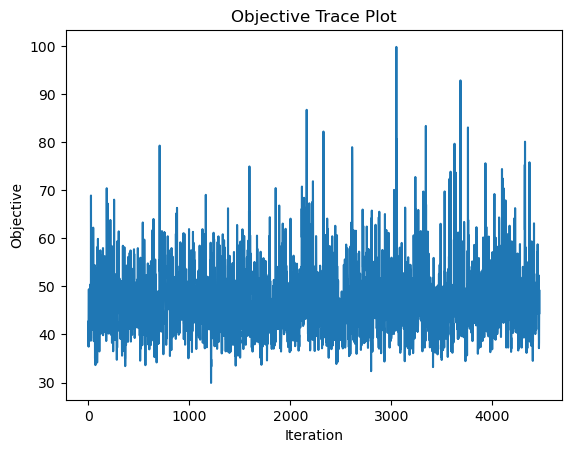

In [100]:
# make a trace plot of objective
plt.plot(objective)
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective Trace Plot')
plt.show()

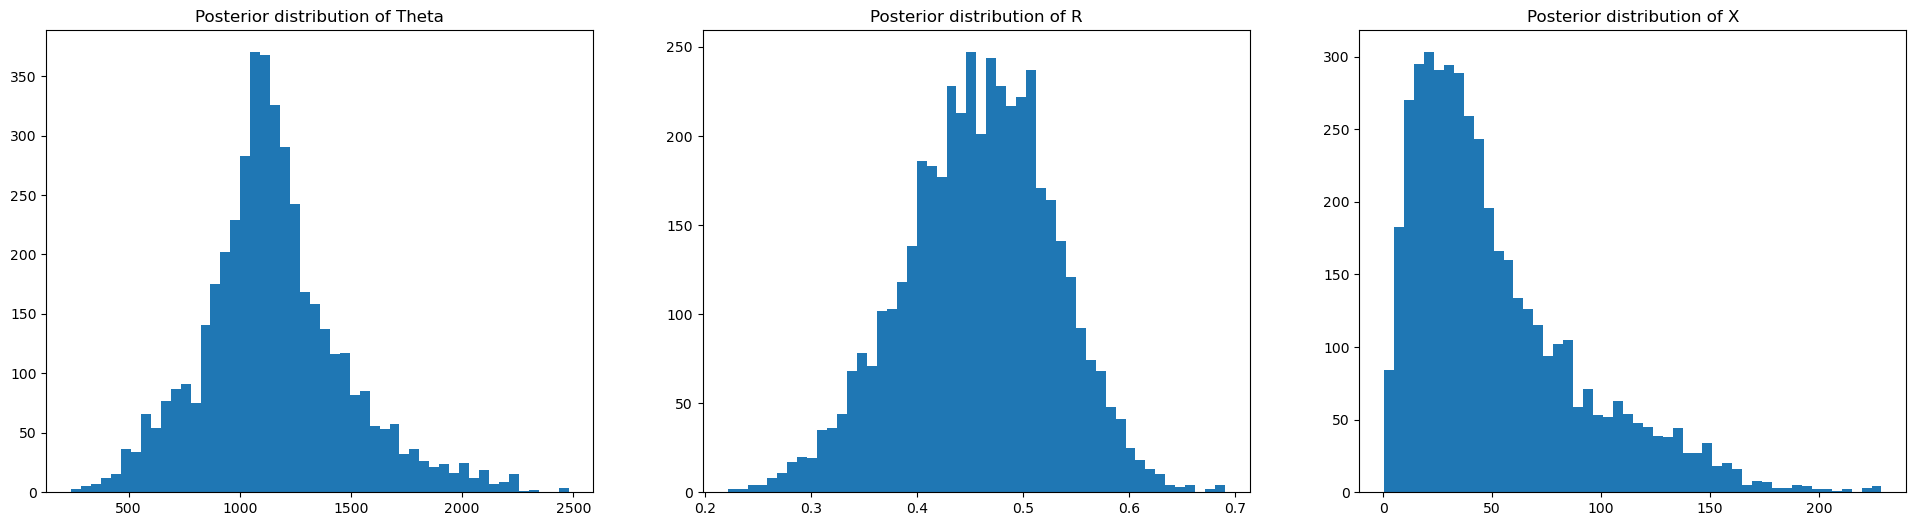

In [101]:
# plot histogram of theta
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
ax1.hist(theta, bins=50)
ax1.set_title('Posterior distribution of Theta')
ax2.hist(w**(ds / delta_c), bins=50)
ax2.set_title('Posterior distribution of R')
ax3.hist(x[:,0], bins=50)
ax3.set_title('Posterior distribution of X')
plt.show()

In [102]:
test_depths = np.arange(depths.min(), depths.max() + 1, 1)
results = np.array([np.array([G(theta[i], x[i], d) for i in range(len(theta))]) for d in test_depths])

In [103]:
r = (100 - 95) / 2
lower_bound = np.percentile(results, r, axis=1)
upper_bound = np.percentile(results, 100 - r, axis=1)

filtered_results = {}

for i in range(len(test_depths)):
    filtered_results[i] = results[i][(results[i] >= lower_bound[i]) & (results[i] <= upper_bound[i])]

In [175]:
result_frame = pd.DataFrame(columns=['depth', 'min', 'max', 'median', 'mean'])

for i in range(len(results)):
    result_frame.loc[i] = [test_depths[i], round(np.min(filtered_results[i]), 2), round(np.max(filtered_results[i]), 2), round(np.median(filtered_results[i]), 2), round(np.mean(filtered_results[i]), 2)]

result_frame.to_csv('results.csv')


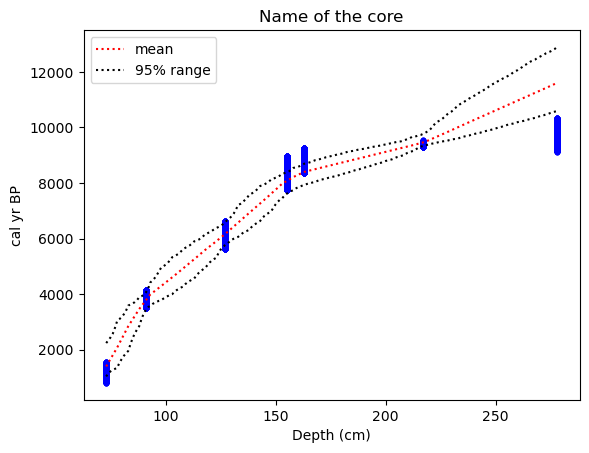

In [174]:
# plotting
ax = plt.subplot()
ax.plot(result_frame['depth'], result_frame['mean'], ':', c='red', label='mean')
ax.plot(result_frame['depth'], result_frame['min'], ':', c='black', label=f'{confidence_range}% range')
ax.plot(result_frame['depth'], result_frame['max'], ':', c='black')
for i, data in dataset.iterrows():
    calibrated = calibrate(data['age'], data['error'])
    ax.scatter(data['depth'].repeat(calibrated['ages'].size), calibrated['ages'], marker='o', c='blue', s=10)

ax.set_xlabel('Depth (cm)')
ax.set_ylabel('cal yr BP')
ax.set_title('Name of the core')
ax.legend()